In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch

import numpy as np
import matplotlib.pyplot as plt

from DGBaN import ring_dataset, randomized_ring_dataset, DGBaNR

/home/J000000000007/envs/DGBaN/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load dataset:

In [6]:
dataset_generator = randomized_ring_dataset(N=32)
features, imgs = dataset_generator.generate_dataset(data_size=64000, seed=42, device='cpu', test_return=True)

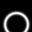

In [7]:
gaussian_ring, center, mean, sig = dataset_generator.gaussian_ring(1)
gaussian_ring, center, mean, sig = gaussian_ring[0], center[0], mean[0], sig[0]

features = torch.Tensor([[center[0], center[1], mean, sig, gaussian_ring.mean() * 32 * 32]])

Image.fromarray((gaussian_ring.reshape((32, 32)) * 255).astype(np.uint8))

Load generator:

In [8]:
generator = DGBaNR(dataset_generator.n_features, img_size=32)
generator.load_state_dict(torch.load('save_model/DGBaNR_64000_64_RMSprop_mse_loss_50.pt', map_location=torch.device('cpu')))
generator.eval()

DGBaNR(
  (linear): LinearReparameterization()
  (conv1): ConvTranspose2dReparameterization()
  (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2dReparameterization()
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2dReparameterization()
)

In [12]:
feature = torch.Tensor(dataset_generator.scaler.transform(np.array([[9.0000, 20.0000, 11.4000, 2.6000, 246.8282] for i in range(255 * 50)])))

In [13]:
pred_ring = np.zeros((32, 32))
with torch.no_grad():
    pred_rings = generator(feature)[0].numpy().squeeze()

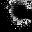

In [21]:
Image.fromarray((pred_rings / 40).sum(axis=0).astype(np.uint8))

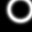

In [108]:
Image.fromarray((dataset_generator.gaussian_from_features((9, 20), 11.4, 2.6) * 255).astype(np.uint8))

In [23]:
(np.abs((pred_rings / 50).sum(axis=0) - (dataset_generator.gaussian_from_features((9, 20), 11.4, 2.6) * 255)).astype(np.uint8)).mean()

46.1005859375

In [20]:
(dataset_generator.gaussian_from_features((9, 20), 11.4, 2.6) * 255).astype(np.uint8).mean()

61.1279296875

In [70]:
features[0]

tensor([  9.0000,  20.0000,  11.4000,   2.6000, 246.8282])

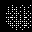

In [71]:
Image.fromarray(generator(torch.Tensor([[9.0000, 20.0000, 11.4000, 2.6000, 246.8282]]))[0].detach().numpy().squeeze().astype(np.bool))